In [1]:
import torch, torchvision
from replace_Backbone import CSPdarkNetWithFPN
backbone = CSPdarkNetWithFPN()

In [2]:
from train_voc import pascol_voc_Dataset, get_transform, utils
dataset = pascol_voc_Dataset(transforms=get_transform(train=True))
dataset_test = pascol_voc_Dataset(transforms=get_transform(train=False), txt_name='val.txt')
num_classes = dataset.classNUM

print(f'dataset size :{len(dataset),len(dataset_test)}')
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=True, num_workers=8,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=4, shuffle=False, num_workers=8,
    collate_fn=utils.collate_fn)

dataset size :(5717, 5823)


In [3]:
# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]

展示一下图片

In [4]:
from torchvision.transforms import ToPILImage, functional as F
from torchvision.utils import draw_bounding_boxes
# transform_back = ToPILImage()
# pilIMAGE = [transform_back(img.clone()) for img in images]
pilIMAGE = [F.convert_image_dtype(img.clone(), dtype=torch.uint8) for img in images]
classes = dataset.classesNAME

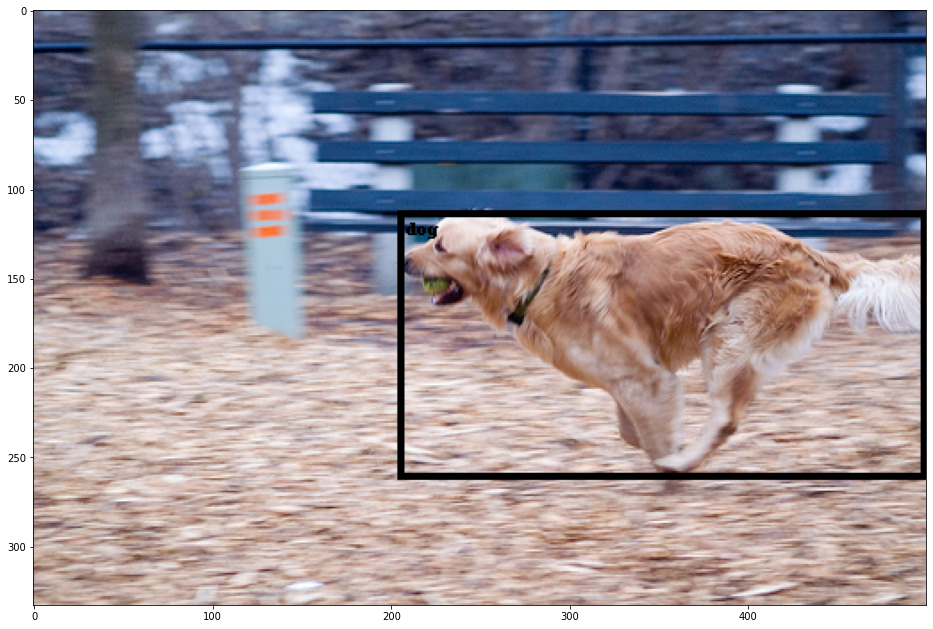

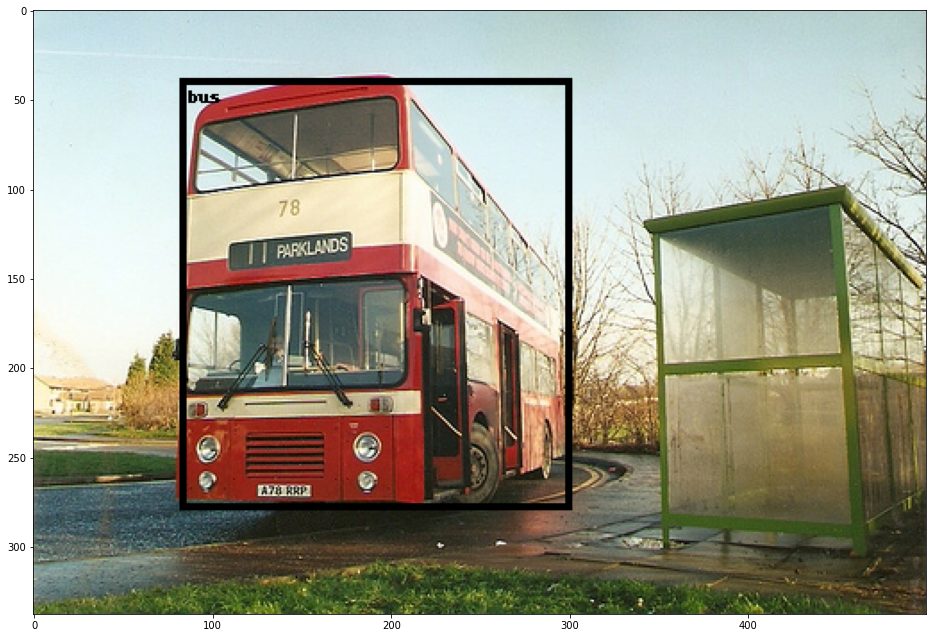

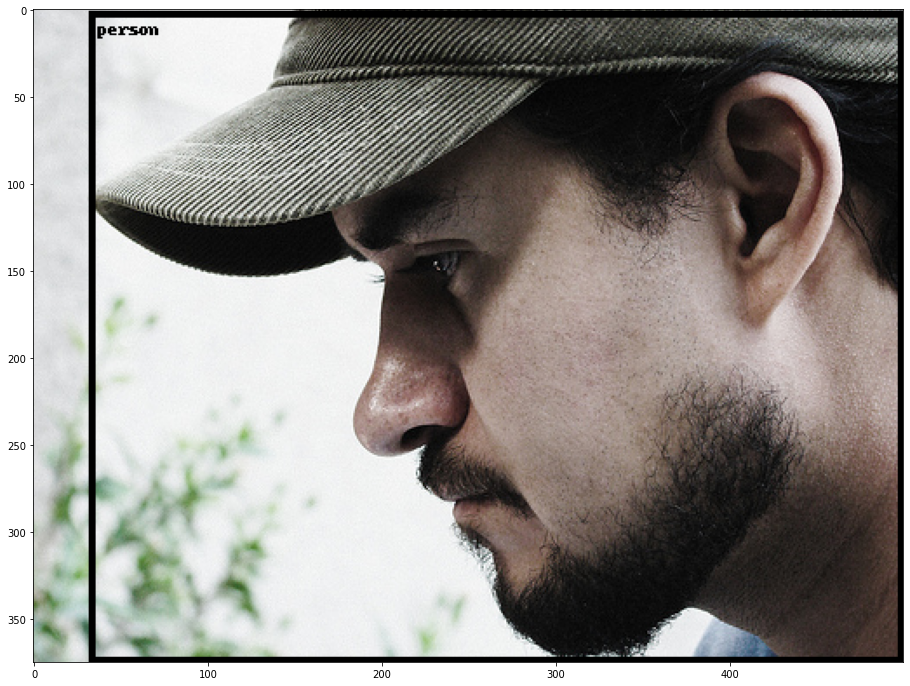

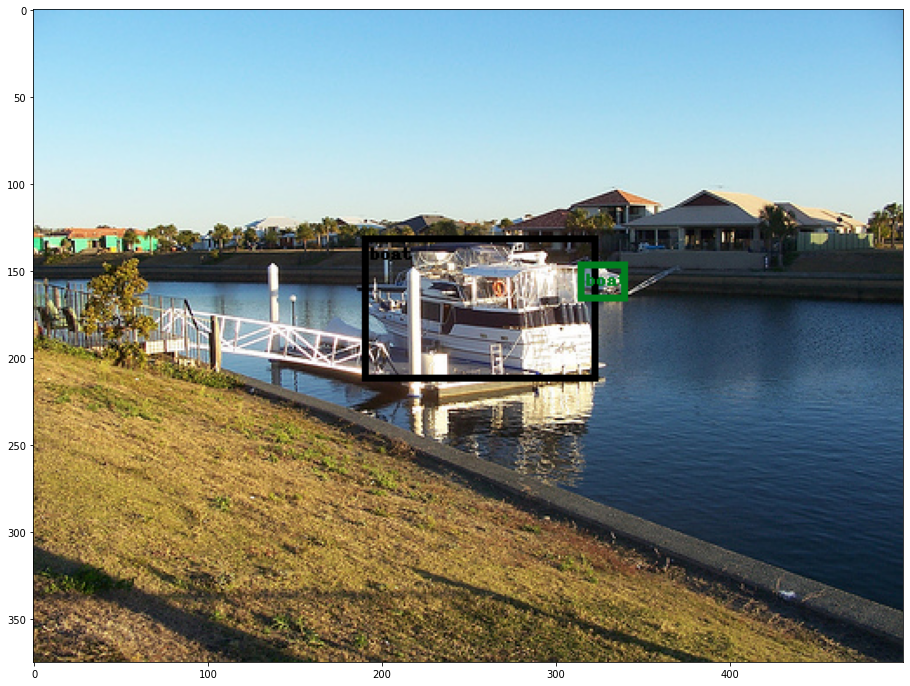

In [5]:
score_threshold = .8
result = []
for res in range(len(pilIMAGE)):
    boxes = targets[res]['boxes']
    labels = targets[res]['labels']
    labels = [classes[i] for i in labels]
        
    drawn_boxes = draw_bounding_boxes(pilIMAGE[res], boxes=boxes, labels=labels, width=4, font_size=30)
    result.append(F.to_pil_image(drawn_boxes))
from matplotlib import pyplot as plt
for i in result:
    fig = plt.figure(figsize=(16, 12))
    plt.subplot(1, 1, 1)
    plt.imshow(i)

In [6]:
for img,target in zip(images,targets):
    print(img.shape,target)

torch.Size([3, 333, 500]) {'boxes': tensor([[204., 112., 500., 262.]]), 'labels': tensor([1]), 'image_id': tensor([1435]), 'area': tensor([44400.]), 'iscrowd': tensor([0])}
torch.Size([3, 338, 500]) {'boxes': tensor([[ 82.,  38., 301., 279.]]), 'labels': tensor([4]), 'image_id': tensor([3026]), 'area': tensor([52779.]), 'iscrowd': tensor([0])}
torch.Size([3, 375, 500]) {'boxes': tensor([[ 32.,   1., 500., 375.]]), 'labels': tensor([2]), 'image_id': tensor([2673]), 'area': tensor([175032.]), 'iscrowd': tensor([0])}
torch.Size([3, 375, 500]) {'boxes': tensor([[189., 130., 324., 213.],
        [313., 145., 341., 167.]]), 'labels': tensor([14, 14]), 'image_id': tensor([5668]), 'area': tensor([11205.,   616.]), 'iscrowd': tensor([0, 0])}


In [7]:
from typing import Tuple, List
from torchvision.models.detection.transform import GeneralizedRCNNTransform
original_image_sizes: List[Tuple[int, int]] = []
image_mean = [0.485, 0.456, 0.406]
image_std = [0.229, 0.224, 0.225]
Gen_transform = GeneralizedRCNNTransform(600, 800, image_mean, image_std)

for img in images:
    val = img.shape[-2:]
    print(val)
    assert len(val) == 2
    original_image_sizes.append((val[0], val[1]))

images, targets = Gen_transform(images, targets)

torch.Size([333, 500])
torch.Size([338, 500])
torch.Size([375, 500])
torch.Size([375, 500])


In [8]:
for img,target in zip(images.tensors,targets):
    print(img.shape,target)

torch.Size([3, 608, 800]) {'boxes': tensor([[326.4000, 178.9309, 800.0000, 418.5706]]), 'labels': tensor([1]), 'image_id': tensor([1435]), 'area': tensor([44400.]), 'iscrowd': tensor([0])}
torch.Size([3, 608, 800]) {'boxes': tensor([[131.2000,  60.7101, 481.6000, 445.7397]]), 'labels': tensor([4]), 'image_id': tensor([3026]), 'area': tensor([52779.]), 'iscrowd': tensor([0])}
torch.Size([3, 608, 800]) {'boxes': tensor([[ 51.2000,   1.6000, 800.0000, 600.0000]]), 'labels': tensor([2]), 'image_id': tensor([2673]), 'area': tensor([175032.]), 'iscrowd': tensor([0])}
torch.Size([3, 608, 800]) {'boxes': tensor([[302.4000, 208.0000, 518.4000, 340.8000],
        [500.8000, 232.0000, 545.6000, 267.2000]]), 'labels': tensor([14, 14]), 'image_id': tensor([5668]), 'area': tensor([11205.,   616.]), 'iscrowd': tensor([0, 0])}


# 1. Anchor 生成器

In [9]:
# sizes 数量对应与FPN的不同尺度的特征图数量
sizes=((32,),(64,),(128,),(256,))
aspect_ratios=((0.5, 1.0, 2.0),) * len(sizes)
# anchor模板是怎样生成锚框的
for size, aspect_ratio in zip(sizes, aspect_ratios):
    print(size,aspect_ratio)
    size = torch.as_tensor(size)
    aspect_ratio = torch.as_tensor(aspect_ratio)
    print(size.shape, aspect_ratio.shape)
    print(size[None,:].shape, aspect_ratio[:,None].shape)

# 根据anchor模板参数生成对应的anchors模板
# 在特征图的每一个pixel还原到原图上的区域
# 以区域的左上角点为中心生成对应模板的锚框
from typing import List
def generate_anchors(
    scales: List[int],
    aspect_ratios: List[float],
    dtype: torch.dtype = torch.float32,
    device: torch.device = torch.device("cpu"),
):
    scales = torch.as_tensor(scales, dtype=dtype, device=device)
    aspect_ratios = torch.as_tensor(aspect_ratios, dtype=dtype, device=device)
    h_ratios = torch.sqrt(aspect_ratios)
    w_ratios = 1 / h_ratios

    ws = (w_ratios[:, None] * scales[None, :]).view(-1)
    hs = (h_ratios[:, None] * scales[None, :]).view(-1)

    base_anchors = torch.stack([-ws, -hs, ws, hs], dim=1) / 2
    return base_anchors.round()
cell_anchors = [
    generate_anchors(
        scales, aspect_ratio) for scales, aspect_ratio in zip(sizes, aspect_ratios)
    ]
print(cell_anchors,len(cell_anchors[0]))

(32,) (0.5, 1.0, 2.0)
torch.Size([1]) torch.Size([3])
torch.Size([1, 1]) torch.Size([3, 1])
(64,) (0.5, 1.0, 2.0)
torch.Size([1]) torch.Size([3])
torch.Size([1, 1]) torch.Size([3, 1])
(128,) (0.5, 1.0, 2.0)
torch.Size([1]) torch.Size([3])
torch.Size([1, 1]) torch.Size([3, 1])
(256,) (0.5, 1.0, 2.0)
torch.Size([1]) torch.Size([3])
torch.Size([1, 1]) torch.Size([3, 1])
[tensor([[-23., -11.,  23.,  11.],
        [-16., -16.,  16.,  16.],
        [-11., -23.,  11.,  23.]]), tensor([[-45., -23.,  45.,  23.],
        [-32., -32.,  32.,  32.],
        [-23., -45.,  23.,  45.]]), tensor([[-91., -45.,  91.,  45.],
        [-64., -64.,  64.,  64.],
        [-45., -91.,  45.,  91.]]), tensor([[-181.,  -91.,  181.,   91.],
        [-128., -128.,  128.,  128.],
        [ -91., -181.,   91.,  181.]])] 3


每一个特征图网格生成对应数量的锚框（3个，上例）

In [10]:
image_size = images.tensors.shape[-2:]
print(f'原图尺寸: {image_size}')
# 经过FPN提取的特征图
feature_maps = backbone(images.tensors)
grid_sizes = list([v.shape[-2:] for v in feature_maps.values()])
print('grid_sizes: 特征图的尺寸')
for i in grid_sizes:
    print(i
    )
print('***')
# 获取每一个特征图的每一个像素坐标相对于原图的坐标的比例
strides = [
    [
        torch.tensor(image_size[0] // g[0], dtype=torch.int64),
        torch.tensor(image_size[1] // g[1], dtype=torch.int64),
    ]
    for g in grid_sizes
]
print('strides: 特征图相对于原图的步距')
for i in strides:
    print(i)

原图尺寸: torch.Size([608, 800])
grid_sizes: 特征图的尺寸
torch.Size([76, 100])
torch.Size([38, 50])
torch.Size([19, 25])
torch.Size([10, 13])
***
strides: 特征图相对于原图的步距
[tensor(8), tensor(8)]
[tensor(16), tensor(16)]
[tensor(32), tensor(32)]
[tensor(60), tensor(61)]


In [11]:
# 特征图数量和布局、anchor数量要一致
# 每一个尺度的特征图都对应不同的步距，使用对应的anchor模板，以下标对应
assert (len(grid_sizes) == len(strides) == len(cell_anchors))

获取所有特征图的anchor模板

In [12]:
anchors_over_all_feature_maps = []
#特征图大小，特征图相对于原图的步距，每一个网格的anchor模板
for size, stride, base_anchors in zip(grid_sizes, strides, cell_anchors):
    print("特征图的大小", "还原回原图的步距", "对应这个特征图的anchor模板","生成对应数量的锚框")
    print(size, stride, base_anchors, size[0]*size[1]*len(base_anchors))

    grid_height, grid_width = size
    stride_height, stride_width = stride
    device = base_anchors.device

    # For output anchor, compute [x_center, y_center, x_center, y_center]
    # 计算特征图每一个pixel还原回原图时的中心坐标位置x,y
    shifts_x = torch.arange(0, grid_width, dtype=torch.int32, device=device) * stride_width
    shifts_y = torch.arange(0, grid_height, dtype=torch.int32, device=device) * stride_height
    
    shift_y, shift_x = torch.meshgrid(shifts_y, shifts_x, indexing="ij")
    shift_x = shift_x.reshape(-1)
    shift_y = shift_y.reshape(-1)
    # 网格中心点坐标
    shifts = torch.stack((shift_x, shift_y, shift_x, shift_y), dim=1)

    # For every (base anchor, output anchor) pair,
    # offset each zero-centered base anchor by the center of the output anchor.
    a = shifts.view(-1, 1, 4)
    b = base_anchors.view(1, -1, 4)
    c = a + b
    print(c.shape)
    # 把anchor模板 应用到每一个网格，生成anchors
    anchors_over_all_feature_maps.append(c.reshape(-1, 4))

特征图的大小 还原回原图的步距 对应这个特征图的anchor模板 生成对应数量的锚框
torch.Size([76, 100]) [tensor(8), tensor(8)] tensor([[-23., -11.,  23.,  11.],
        [-16., -16.,  16.,  16.],
        [-11., -23.,  11.,  23.]]) 22800
torch.Size([7600, 3, 4])
特征图的大小 还原回原图的步距 对应这个特征图的anchor模板 生成对应数量的锚框
torch.Size([38, 50]) [tensor(16), tensor(16)] tensor([[-45., -23.,  45.,  23.],
        [-32., -32.,  32.,  32.],
        [-23., -45.,  23.,  45.]]) 5700
torch.Size([1900, 3, 4])
特征图的大小 还原回原图的步距 对应这个特征图的anchor模板 生成对应数量的锚框
torch.Size([19, 25]) [tensor(32), tensor(32)] tensor([[-91., -45.,  91.,  45.],
        [-64., -64.,  64.,  64.],
        [-45., -91.,  45.,  91.]]) 1425
torch.Size([475, 3, 4])
特征图的大小 还原回原图的步距 对应这个特征图的anchor模板 生成对应数量的锚框
torch.Size([10, 13]) [tensor(60), tensor(61)] tensor([[-181.,  -91.,  181.,   91.],
        [-128., -128.,  128.,  128.],
        [ -91., -181.,   91.,  181.]]) 390
torch.Size([130, 3, 4])


In [13]:
# 不同比例的模板展平 每个网格的三个比例的anchro连着
for i in anchors_over_all_feature_maps:
    print(i.shape)

torch.Size([22800, 4])
torch.Size([5700, 4])
torch.Size([1425, 4])
torch.Size([390, 4])


In [14]:
anchors = []
for _ in range(len(images.image_sizes)):
    anchors_in_image = [anchors_per_feature_map for anchors_per_feature_map in anchors_over_all_feature_maps]
    anchors.append(anchors_in_image)
anchors = [torch.cat(anchors_per_image) for anchors_per_image in anchors]

In [15]:
# 将所有特征图的anchor模板拼接到一起
# 26400:32(0.5,1.0,2.0) + 6600:64(0.5,1.0,2.0) + 1650:128(0.5,1.0,2.0) + 429:256(0.5,1.0,2.0)
for i in anchors:
    print(i.shape)

torch.Size([30315, 4])
torch.Size([30315, 4])
torch.Size([30315, 4])
torch.Size([30315, 4])


# RPN

proposals, proposal_losses = self.rpn(images, features, targets)

RPN 返回所有proposals 和 proposals 损失

训练阶段输入 图像，特征图，标签

In [16]:
features = list(feature_maps.values())
for i in features:
    print(i.shape)

torch.Size([4, 256, 76, 100])
torch.Size([4, 256, 38, 50])
torch.Size([4, 256, 19, 25])
torch.Size([4, 256, 10, 13])


In [17]:
from torchvision.models.detection.rpn import RPNHead
# RPN检测头 输入通道为FPN特征图通道数256 输出通道为anchor模板数量
# 将特征图输入给RPN头，为每个特征图网格输出anchor数量个 置信度分数和边界框回归参数
head = RPNHead(256,len(cell_anchors[0]))

In [18]:
head
# cls_logits：输出每个网格的每个anchor为前景的置信度 3个anchor 
# bbox_pre： 输出每个网格的每个anchor的边界框偏移参数 3个anchor*4 左上角xy，右下角xy

RPNHead(
  (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cls_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
  (bbox_pred): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
)

In [19]:
objectness, pred_bbox_deltas = head(features)

In [20]:
# 置信度分数
objectness[0].shape,objectness[1].shape,objectness[2].shape,objectness[3].shape,

(torch.Size([4, 3, 76, 100]),
 torch.Size([4, 3, 38, 50]),
 torch.Size([4, 3, 19, 25]),
 torch.Size([4, 3, 10, 13]))

In [21]:
# 边界框偏移参数
pred_bbox_deltas[0].shape,pred_bbox_deltas[1].shape,pred_bbox_deltas[2].shape,pred_bbox_deltas[3].shape,

(torch.Size([4, 12, 76, 100]),
 torch.Size([4, 12, 38, 50]),
 torch.Size([4, 12, 19, 25]),
 torch.Size([4, 12, 10, 13]))

In [22]:
# 图片数量
num_images = len(anchors)

In [23]:
num_anchors_per_level_shape_tensors = [o[0].shape for o in objectness]

In [24]:
# 每一个特征图对应的anchor模板数量
num_anchors_per_level_shape_tensors

[torch.Size([3, 76, 100]),
 torch.Size([3, 38, 50]),
 torch.Size([3, 19, 25]),
 torch.Size([3, 10, 13])]

In [25]:
# 每一个pixel的anchor * H*W
num_anchors_per_level = [s[0] * s[1] * s[2] for s in num_anchors_per_level_shape_tensors]

In [26]:
# 每一个特征图对应的anchor模板数量
num_anchors_per_level

[22800, 5700, 1425, 390]

In [27]:
from torch import Tensor
def permute_and_flatten(layer: Tensor, N: int, A: int, C: int, H: int, W: int
) -> Tensor:
    # 4, 3, 40, 80
    # 4, 12, 40, 80
    # 4, A:3, C:1, H:40, W:80 C类别
    # 4, A:3, C:4, H:40, W:80 C边界框
    layer = layer.view(N, -1, C, H, W) #添加一个维度
    # N, H=40, W=80, 3, C=1
    layer = layer.permute(0, 3, 4, 1, 2)
    # 高宽展平 H*W*3,1 每一个特征图上的3个锚框展平 预测为前景的概率
    # 边界框：HW*3,4 每个预测框相对于锚框的回归参数
    layer = layer.reshape(N, -1, C)
    return layer

In [28]:
box_cls, box_regression = objectness, pred_bbox_deltas # 把预测的结果展平，对齐标签
box_cls_flattened = []
box_regression_flattened = []

for box_cls_per_level, box_regression_per_level in zip(box_cls, box_regression):
    # 批量大小，RPN anchor数量*类别（前景或者背景BCE loss，所以C=1），高，宽
    N, AxC, H, W = box_cls_per_level.shape
    Ax4 = box_regression_per_level.shape[1]
    A = Ax4 // 4
    C = AxC // A
    box_cls_per_level = permute_and_flatten(box_cls_per_level, N, A, C, H, W)
    box_cls_flattened.append(box_cls_per_level)

    box_regression_per_level = permute_and_flatten(
        box_regression_per_level, N, A, 4, H, W)
    box_regression_flattened.append(box_regression_per_level)

In [29]:
# 预测的不同特征图的 置信度分数和边界框回归参数
for cls,reg in zip(box_cls_flattened, box_regression_flattened):
    print(cls.shape,reg.shape)

torch.Size([4, 22800, 1]) torch.Size([4, 22800, 4])
torch.Size([4, 5700, 1]) torch.Size([4, 5700, 4])
torch.Size([4, 1425, 1]) torch.Size([4, 1425, 4])
torch.Size([4, 390, 1]) torch.Size([4, 390, 4])


In [30]:
# 拼接 把整个batch合并
torch.cat(box_cls_flattened, 
dim=1).shape,torch.cat(box_cls_flattened, dim=1).flatten(0, -2).shape

(torch.Size([4, 30315, 1]), torch.Size([121260, 1]))

In [31]:
torch.cat(box_regression_flattened, 
dim=1).shape,torch.cat(box_regression_flattened, dim=1).reshape(-1, 4).shape

(torch.Size([4, 30315, 4]), torch.Size([121260, 4]))

In [32]:
# 按照训练小批量的标签 shape 展平
box_cls = torch.cat(box_cls_flattened, dim=1).flatten(0, -2)
box_regression = torch.cat(box_regression_flattened, dim=1).reshape(-1, 4)

In [33]:
# 至此，我们已经从RPN head 获取了从这个小批量训练样本得到的所有候选框的类别和边界框回归参数
objectness, pred_bbox_deltas = box_cls, box_regression

In [34]:
# 批量内所有特征图的所有网格的所有预测框的置信度分数和边界框回归参数
# 140316 = 4 * 35097
# 35097 = 26400+6600+1650+429
# 26400 = 3 * 88 * 100 特征图1
# 6600 = 3 * 44 * 50 特征图2
# 1650 = 3 * 22 * 25 特征图3
# 429 = 3 * 11 * 13 特征图4
objectness.shape, pred_bbox_deltas.shape

(torch.Size([121260, 1]), torch.Size([121260, 4]))

## 训练阶段

1. assign_targets_to_anchors  为真实边界框分配正负 锚框
2. 对GT box 进行编码 变成 $t^*_x,t^*_y,t^*_w,t^*_h$
3. 计算损失

In [35]:
from torchvision.ops.boxes import box_iou
box_similarity = box_iou

获取正样本锚框和其标签 （标签就是1，因为只区分是前景还是背景）使用BCE 损失

labels, matched_gt_boxes = self.assign_targets_to_anchors(anchors, targets)

In [36]:
labels = [] # 每个网格的样本类别 正，负，丢弃样本
matched_gt_boxes = [] # 匹配到的锚框的边界框回归参数
low_threshold = 0.3 # 低于IOU阈值的锚框定义为负样本 -1
high_threshold = 0.7 # 正样本IOU阈值 下标
# 在阈值之间的为丢弃样本 -2
for anchors_per_image, targets_per_image in zip(anchors, targets):
    gt_boxes = targets_per_image["boxes"]
    if gt_boxes.numel() == 0:
        # Background image (negative example)
        device = anchors_per_image.device
        matched_gt_boxes_per_image = torch.zeros(anchors_per_image.shape, dtype=torch.float32, device=device)
        labels_per_image = torch.zeros((anchors_per_image.shape[0],), dtype=torch.float32, device=device)
    else:
        # 每一个GT 和 每一个 anchor 的IOU矩阵
        match_quality_matrix = box_similarity(gt_boxes, anchors_per_image)
        # match_quality_matrix 是IOU矩阵，行为真实边界框，列为所有锚框数量35079 IOU大于0 则 相交
        print(match_quality_matrix.shape)
        for i in match_quality_matrix:
            # 与真实边界框 IOU 大于0的锚框数量
            print ((i != 0).nonzero(as_tuple=True)[0].shape)
        # 每一个锚框找到其与真实边界框IOU最大：IOU值  对应的真实边界框是哪一个：下标
        # 有的锚框可能与任意的真实边界框都不相交，则该列为0
        matched_vals, matches = match_quality_matrix.max(dim=0)
        # 获得低于IOU阈值的锚框的位置，低于阈值则为true shape相同
        below_low_threshold = matched_vals < low_threshold
        # 获得IOU阈值处于0.3-0.7之间的锚框的位置
        between_thresholds = (matched_vals >= low_threshold) & (matched_vals < high_threshold)
        all_matches = matches.clone()
        # 把低于阈值的和处于阈值之间的锚框位置更新
        matches[below_low_threshold] = -1
        matches[between_thresholds] = -2
        # 为每一个真实边界框找一个IOU最大的匹配到的锚框，因为上面匹配后可能有某个真实边界框没有任何一个锚框匹配到，IOU都小于0.7
        highest_quality_foreach_gt, tmp = match_quality_matrix.max(dim=1)
        # 找到所有满足阈值的锚框位置
        gt_pred_pairs_of_highest_quality = torch.where(match_quality_matrix == highest_quality_foreach_gt[:, None])
        pred_inds_to_update = gt_pred_pairs_of_highest_quality[1] # 所有匹配到的锚框位置
        print(f'正样本{len(pred_inds_to_update)}')
        matches[pred_inds_to_update] = all_matches[pred_inds_to_update]
        # 匹配到的锚框为正样本的位置
        matched_idxs = matches
        
        # 构造一个GT边界框的副本，每一个位置都是真实边界框的参数
        matched_gt_boxes_per_image = gt_boxes[matched_idxs.clamp(min=0)]

        labels_per_image = matched_idxs >= 0
        labels_per_image = labels_per_image.to(dtype=torch.float32)
        bg_indices = matched_idxs == -1
        labels_per_image[bg_indices] = 0.0  # 负样本为0
        inds_to_discard = matched_idxs == -2 
        labels_per_image[inds_to_discard] = -1.0 # 丢弃样本为-1

    labels.append(labels_per_image)
    matched_gt_boxes.append(matched_gt_boxes_per_image)

torch.Size([1, 30315])
torch.Size([8876])
正样本2
torch.Size([1, 30315])
torch.Size([10734])
正样本2
torch.Size([1, 30315])
torch.Size([28966])
正样本76
torch.Size([2, 30315])
torch.Size([2981])
torch.Size([531])
正样本4


把上述匹配到的锚框的位置坐标参数转换为回归参数形式
regression_targets = self.box_coder.encode(matched_gt_boxes, anchors)

In [37]:
reference_boxes = matched_gt_boxes.copy() #GT边界框
proposals = anchors.copy() # 锚框

In [38]:
boxes_per_image = [len(b) for b in reference_boxes]
# 拼接batch内的所有图片的GT box 参数
reference_boxes = torch.cat(reference_boxes, dim=0)
proposals = torch.cat(proposals, dim=0)

In [39]:
boxes_per_image, reference_boxes.shape, proposals.shape

([30315, 30315, 30315, 30315],
 torch.Size([121260, 4]),
 torch.Size([121260, 4]))

转换参数

$t^*_x = (x^*-x_a)/w_a$

$t^*_y = (y^*-y_a)/h_a$

$t^*_w = \ln(w^*/w_a)$

$t^*_h = \ln(h^*/h_a)$

In [40]:
wx,wy,ww,wh = torch.ones(4)
# x1,y1: 左上 x2,y2: 右下
proposals_x1 = proposals[:, 0].unsqueeze(1)
proposals_y1 = proposals[:, 1].unsqueeze(1)
proposals_x2 = proposals[:, 2].unsqueeze(1)
proposals_y2 = proposals[:, 3].unsqueeze(1)
reference_boxes_x1 = reference_boxes[:, 0].unsqueeze(1)
reference_boxes_y1 = reference_boxes[:, 1].unsqueeze(1)
reference_boxes_x2 = reference_boxes[:, 2].unsqueeze(1)
reference_boxes_y2 = reference_boxes[:, 3].unsqueeze(1)
# anchor中心点坐标和高宽
# implementation starts here
ex_widths = proposals_x2 - proposals_x1
ex_heights = proposals_y2 - proposals_y1
ex_ctr_x = proposals_x1 + 0.5 * ex_widths
ex_ctr_y = proposals_y1 + 0.5 * ex_heights
# GT中心点坐标和高宽
gt_widths = reference_boxes_x2 - reference_boxes_x1
gt_heights = reference_boxes_y2 - reference_boxes_y1
gt_ctr_x = reference_boxes_x1 + 0.5 * gt_widths
gt_ctr_y = reference_boxes_y1 + 0.5 * gt_heights

targets_dx = wx * (gt_ctr_x - ex_ctr_x) / ex_widths
targets_dy = wy * (gt_ctr_y - ex_ctr_y) / ex_heights
targets_dw = ww * torch.log(gt_widths / ex_widths)
targets_dh = wh * torch.log(gt_heights / ex_heights)

targetscopy = torch.cat((targets_dx, targets_dy, targets_dw, targets_dh), dim=1)

In [41]:
targetscopy.shape

torch.Size([121260, 4])

In [42]:
regression_targets = targetscopy.split(boxes_per_image,0)
# 对齐预测输出

In [43]:
for i,j in zip(labels, regression_targets):
    print(i.shape,j.shape)

torch.Size([30315]) torch.Size([30315, 4])
torch.Size([30315]) torch.Size([30315, 4])
torch.Size([30315]) torch.Size([30315, 4])
torch.Size([30315]) torch.Size([30315, 4])


计算损失

compute_loss( *objectness*, *pred_bbox_deltas*, *labels*, *regression_targets*)

- 正负样本采样
- 边界框回归损失
- 类别损失

In [44]:
matched_idxs = labels.copy()

In [45]:
pos_idx = []
neg_idx = []
batch_size_per_image = 256
positive_fraction = 0.5
for matched_idxs_per_image in matched_idxs:
    positive = torch.where(matched_idxs_per_image >= 1)[0]
    negative = torch.where(matched_idxs_per_image == 0)[0]
    num_pos = int(batch_size_per_image * positive_fraction) # 128 正样本
    num_pos = min(positive.numel(), num_pos) # 如果正样本不够128，那就采样全部正样本
    num_neg = batch_size_per_image - num_pos # 负样本数量为 batch_size_per_image - 正样本数量
    num_neg = min(negative.numel(), num_neg) # 如果负样本不够，就采样全部负样本

    perm1 = torch.randperm(positive.numel(), device=positive.device)[:num_pos]
    perm2 = torch.randperm(negative.numel(), device=negative.device)[:num_neg]
    pos_idx_per_image = positive[perm1] # 正样本随机排列
    neg_idx_per_image = negative[perm2] # 负样本随机排列

    pos_idx_per_image_mask = torch.zeros_like(matched_idxs_per_image, dtype=torch.uint8)
    neg_idx_per_image_mask = torch.zeros_like(matched_idxs_per_image, dtype=torch.uint8)

    pos_idx_per_image_mask[pos_idx_per_image] = 1
    neg_idx_per_image_mask[neg_idx_per_image] = 1

    pos_idx.append(pos_idx_per_image_mask)
    neg_idx.append(neg_idx_per_image_mask)
    
sampled_pos_inds, sampled_neg_inds = pos_idx, neg_idx

In [46]:
for i,j in zip(sampled_pos_inds, sampled_neg_inds):
    print(f'+: {torch.where(i)[0].shape}, -: {torch.where(j)[0].shape}')
sampled_pos_inds = torch.where(torch.cat(sampled_pos_inds, dim=0))[0]
sampled_neg_inds = torch.where(torch.cat(sampled_neg_inds, dim=0))[0]

+: torch.Size([2]), -: torch.Size([254])
+: torch.Size([2]), -: torch.Size([254])
+: torch.Size([76]), -: torch.Size([180])
+: torch.Size([4]), -: torch.Size([252])


In [47]:
# 整个批量的所有正负样本4*256
sampled_pos_inds.shape,sampled_neg_inds.shape

(torch.Size([84]), torch.Size([940]))

In [48]:
sampled_inds = torch.cat([sampled_pos_inds, sampled_neg_inds], dim=0)
print(objectness.shape)
objectness = objectness.flatten()
labels = torch.cat(labels, dim=0)
regression_targets = torch.cat(regression_targets, dim=0)
# 整个批量的类别标签（0，1），边界框回归参数标签

torch.Size([121260, 1])


In [49]:
print(labels.shape,objectness.shape,pred_bbox_deltas.shape,regression_targets.shape,)

torch.Size([121260]) torch.Size([121260]) torch.Size([121260, 4]) torch.Size([121260, 4])


In [50]:
import torch.nn.functional as lossF
box_loss = (
    lossF.smooth_l1_loss(
        # 只计算正样本的边界框回归参数
        pred_bbox_deltas[sampled_pos_inds],
        regression_targets[sampled_pos_inds],
        reduction='sum'
    )/ (sampled_inds.numel())
)
objectness_loss = lossF.binary_cross_entropy_with_logits(
    # 计算全部正负样本的前景和背景的损失
    objectness[sampled_inds],
    labels[sampled_inds]
)

In [51]:
box_loss, objectness_loss

(tensor(0.0999, grad_fn=<DivBackward0>),
 tensor(0.6951, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>))

apply pred_bbox_deltas to anchors to obtain the decoded proposals

将预测的边界框回归参数应用到anchor上，获得预测的边界框坐标

In [52]:
rel_codes, boxes = pred_bbox_deltas, anchors
# 将小批量中的anchor全部拼接到一起
boxes_per_image = [b.size(0) for b in boxes]
concat_boxes = torch.cat(boxes, dim=0)

In [53]:
concat_boxes.shape # (9600+2400+600+150)*barchsize, 4

torch.Size([121260, 4])

In [54]:
box_sum = 0
for val in boxes_per_image:
    box_sum += val

In [55]:
box_sum

121260

In [56]:
print(rel_codes.shape)
rel_codes = rel_codes.reshape(box_sum, -1)
print(rel_codes.shape)

torch.Size([121260, 4])
torch.Size([121260, 4])


In [57]:
boxes = concat_boxes
boxes = boxes.to(rel_codes.dtype)

In [58]:
boxes[0]
# xmin,ymax,xmax,ymin

tensor([-23., -11.,  23.,  11.])

$t_i = [t_x,t_y,t_w,t_h]$ --- $t_i$表示预测的第i个anchor的边界框回归参数: prediction

代码中使用$d_i = [d_x,d_y,d_w,d_h]$表示

$t^*_i = [t^*_x,t^*_y,t^*_w,t^*_h]$ --- $t^*_i$表示第i个anchor对应的真实边界框的回归参数: target


$t_x = (x-x_a)/w_a$ --- $t_x$是网络的预测$x$坐标的偏移，$x$是预测边界框的中心坐标，$x_a$是锚框的中心$x$坐标 ---> $x = t_x * w_a + x_a$

$t_y = (y-y_a)/h_a$ --- $t_y$是网络的预测$y$坐标的偏移，$y$是预测边界框的中心坐标，$y_a$是锚框的中心$y$坐标 ---> $y = t_y * h_a + y_a$

$t_w = \ln(w/w_a)$ --- $t_w$是网络的预测宽度的偏移，$w$是预测边界框的宽度，$w_a$是锚框的宽度 ---> $w = e^{t_w} * w_a$

$t_h = \ln(h/h_a)$ --- $t_h$是网络的预测高度偏移，$h$是预测边界框的高度，$h_a$是锚框的高度 ---> $h = e^{t_h} * h_a$

以下都是真实边界框数据根据公式对应锚框计算所得参数: $t^*_x,t^*_y,t^*_w,t^*_h$ 其中$(x^*,y^*,w^*,h^*)$是真实边界框的中心点坐标和高宽

$t^*_x = (x^*-x_a)/w_a$

$t^*_y = (y^*-y_a)/h_a$

$t^*_w = \ln(w^*/w_a)$

$t^*_h = \ln(h^*/h_a)$

In [59]:
# 获取所有锚框的宽和高以及中心坐标 y轴向下为正，x轴向右为正
widths = boxes[:, 2] - boxes[:, 0] # w = xmax-xmin
heights = boxes[:, 3] - boxes[:, 1] # h = abs(ymax-ymin)
ctr_x = boxes[:, 0] + 0.5 * widths # x = xmin + 0.5*w
ctr_y = boxes[:, 1] + 0.5 * heights # y = abs(ymax) - 0.5*h
# weights暂时没用
weights = (1,1,1,1)
wx, wy, ww, wh = weights

# 获取预测边界框回归参数的dx,dy,dw,dh
dx = rel_codes[:, 0::4] / wx #所有预测框的x偏移参数
dy = rel_codes[:, 1::4] / wy #所有y的偏移参数
dw = rel_codes[:, 2::4] / ww #宽的偏移参数
dh = rel_codes[:, 3::4] / wh #高的偏移参数

import math
bbox_xform_clip: float = math.log(1000.0 / 16)
# Prevent sending too large values into torch.exp()
# 防止指数爆炸
dw = torch.clamp(dw, max=bbox_xform_clip)
dh = torch.clamp(dh, max=bbox_xform_clip)

In [60]:
widths.shape, dx.shape

(torch.Size([121260]), torch.Size([121260, 1]))

$x = d_x * w_a + x_a$

$y = d_y * h_a + y_a$

$w = e^{d_w} * w_a$

$h = e^{d_h} * h_a$

预测中心坐标和高宽

In [61]:
pred_ctr_x = dx * widths[:, None] + ctr_x[:, None]
pred_ctr_y = dy * heights[:, None] + ctr_y[:, None]
pred_w = torch.exp(dw) * widths[:, None]
pred_h = torch.exp(dh) * heights[:, None]

坐标是沿着Y轴向下为增大，沿着X轴向右为增大

pred_boxes1 左上x

pred_boxes2 左上y

pred_boxes3 右下x

pred_boxes4 右下x

In [62]:
# Distance from center to box's corner.
c_to_c_h = torch.tensor(0.5, dtype=pred_ctr_y.dtype, device=pred_h.device) * pred_h
c_to_c_w = torch.tensor(0.5, dtype=pred_ctr_x.dtype, device=pred_w.device) * pred_w
pred_boxes1 = pred_ctr_x - c_to_c_w #xmin = center_x - w/2
pred_boxes2 = pred_ctr_y - c_to_c_h #ymax = center_y - h/2
pred_boxes3 = pred_ctr_x + c_to_c_w #xmax = center_x + w/2
pred_boxes4 = pred_ctr_y + c_to_c_h #ymin = center_y + h/2

In [63]:
pred_boxes1.shape

torch.Size([121260, 1])

In [64]:
pred_boxes = torch.stack((
    pred_boxes1, pred_boxes2, pred_boxes3, pred_boxes4), dim=2).flatten(1)

In [65]:
pred_boxes.shape

torch.Size([121260, 4])

In [66]:
pred_boxes_ = torch.cat(
    (pred_boxes1,pred_boxes2,pred_boxes3,pred_boxes4),dim=1)

In [67]:
pred_boxes_.shape

torch.Size([121260, 4])

In [68]:
pred_boxes == pred_boxes_

tensor([[True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        ...,
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True]])

至此，获取到所有预测框在原图上的坐标

In [69]:
pred_boxes = pred_boxes.reshape(box_sum, -1, 4)

In [70]:
pred_boxes.shape

torch.Size([121260, 1, 4])

In [71]:
# 获取所有proposals
proposals = pred_boxes
proposals = proposals.view(num_images, -1, 4)

In [72]:
proposals.shape

torch.Size([4, 30315, 4])

In [73]:
proposals[0]

tensor([[-22.3372, -11.2906,  23.5495,  10.6747],
        [-15.2860, -15.5103,  16.7298,  15.7896],
        [-10.6489, -22.7793,  11.3900,  22.9637],
        ...,
        [552.5292, 451.3569, 914.0765, 636.2942],
        [609.5079, 416.9394, 867.2634, 670.1508],
        [640.8896, 360.9329, 822.4017, 723.4439]], grad_fn=<SelectBackward0>)

## 过滤proposals

In [74]:
num_images = proposals.shape[0]

In [75]:
num_images

4

In [76]:
objectness = objectness.detach()

In [77]:
objectness.shape

torch.Size([121260])

In [78]:
objectness = objectness.reshape(num_images, -1)
objectness.shape

torch.Size([4, 30315])

In [79]:
levels = [
    torch.full((n,), idx, dtype=torch.int64, device=device) for idx, n in enumerate(num_anchors_per_level)
]

In [80]:
# 每一个特征图的网格数量
for i in levels:
    print(i.shape, i[0])

torch.Size([22800]) tensor(0)
torch.Size([5700]) tensor(1)
torch.Size([1425]) tensor(2)
torch.Size([390]) tensor(3)


In [81]:
# 不同特征图的拼接到一起
levels = torch.cat(levels, 0)
levels.shape

torch.Size([30315])

In [82]:
levels = levels.reshape(1, -1).expand_as(objectness)
levels.shape

torch.Size([4, 30315])

In [83]:
objectness.shape, num_anchors_per_level

(torch.Size([4, 30315]), [22800, 5700, 1425, 390])

In [84]:
objectness[0],objectness[0][0],
# 每一个预测框中是否是前景（包含目标）的概率

(tensor([ 0.0087,  0.0146,  0.0142,  ..., -0.0039, -0.0012,  0.0218]),
 tensor(0.0087))

NMS之前选择 top N

In [85]:
# 把候选目标按照特征图结构分开
for ob in objectness.split(num_anchors_per_level, 1):
    print(ob.shape)

torch.Size([4, 22800])
torch.Size([4, 5700])
torch.Size([4, 1425])
torch.Size([4, 390])


In [86]:
rpn_pre_nms_top_n_train=2000
rpn_post_nms_top_n_train=1500
rpn_pre_nms_top_n_test = 1000
rpn_post_nms_top_n_test = 1000
rpn_pre_nms_top_n = dict(training=rpn_pre_nms_top_n_train, testing=rpn_pre_nms_top_n_test)
rpn_post_nms_top_n = dict(training=rpn_post_nms_top_n_train, testing=rpn_post_nms_top_n_test)
rpn_pre_nms_top_n, rpn_post_nms_top_n

({'training': 2000, 'testing': 1000}, {'training': 1500, 'testing': 1000})

In [87]:
r = []
offset = 0

for ob in objectness.split(num_anchors_per_level, 1):
    # 该特征图的anchor数量
    num_anchors = ob.shape[1]
    pre_nms_top_n = min(rpn_pre_nms_top_n['training'], num_anchors)
    # topk 在给定维度选择topk个最大的值，返回按照从大到小排序的值和其在tensor中的下标，
    values_topk, top_n_idx = ob.topk(pre_nms_top_n, dim=1)
    print(values_topk[0,:3], top_n_idx[0,:3])
    print(values_topk.shape, top_n_idx.shape)
    # 把候选集的收集起来，由于最后要展平对应下标，所有要加上偏移量
    r.append(top_n_idx + offset)
    offset += num_anchors
    print(offset)

tensor([0.3046, 0.2947, 0.2879]) tensor([3257, 5210, 5207])
torch.Size([4, 2000]) torch.Size([4, 2000])
22800
tensor([0.1857, 0.1701, 0.1585]) tensor([1408, 1404,  340])
torch.Size([4, 2000]) torch.Size([4, 2000])
28500
tensor([0.0413, 0.0400, 0.0372]) tensor([601, 437, 751])
torch.Size([4, 1425]) torch.Size([4, 1425])
29925
tensor([0.0401, 0.0379, 0.0358]) tensor([235,  63, 274])
torch.Size([4, 390]) torch.Size([4, 390])
30315


In [88]:
top_n_idx = torch.cat(r, dim=1)
top_n_idx.shape

torch.Size([4, 5815])

In [89]:
# 每一张图片的每一个特征层的 TOP N 的集合
top_n_idx[0],top_n_idx[1],

(tensor([ 3257,  5210,  5207,  ..., 30216, 30213, 30228]),
 tensor([ 6662,  6092,  6065,  ..., 30189, 29972, 30011]))

In [90]:
image_range = torch.arange(num_images, device=device)

In [91]:
image_range

tensor([0, 1, 2, 3])

In [92]:
batch_idx = image_range[:, None]
batch_idx

tensor([[0],
        [1],
        [2],
        [3]])

In [93]:
objectness.shape

torch.Size([4, 30315])

In [94]:
# 将topk个候选集从objectness中拿出来
objectness[batch_idx, top_n_idx].shape

torch.Size([4, 5815])

In [95]:
objectness = objectness[batch_idx, top_n_idx]

In [96]:
levels = levels[batch_idx, top_n_idx]

In [97]:
levels.shape

torch.Size([4, 5815])

In [98]:
proposals = proposals[batch_idx, top_n_idx]

In [99]:
proposals.shape

torch.Size([4, 5815, 4])

In [100]:
proposals[0]

tensor([[672.7104,  65.0909, 690.1661, 114.3498],
        [280.6923, 120.7681, 302.4570, 164.7519],
        [271.9296, 125.4571, 293.7070, 164.4368],
        ...,
        [194.5342, 329.9192, 560.3092, 515.9498],
        [132.7636, 329.9221, 499.1736, 515.9979],
        [439.0111, 329.1026, 806.8091, 516.6556]], grad_fn=<SelectBackward0>)

In [101]:
objectness_prob = torch.sigmoid(objectness)

In [102]:
objectness_prob,objectness_prob.shape

(tensor([[0.5756, 0.5732, 0.5715,  ..., 0.4914, 0.4909, 0.4899],
         [0.5993, 0.5862, 0.5825,  ..., 0.4931, 0.4923, 0.4915],
         [0.6431, 0.6388, 0.6342,  ..., 0.4707, 0.4684, 0.4607],
         [0.6018, 0.5910, 0.5832,  ..., 0.4920, 0.4917, 0.4910]]),
 torch.Size([4, 5815]))

In [103]:
final_boxes = []
final_scores = []
image_shapes = image_size

In [104]:
from torchvision.ops.boxes import clip_boxes_to_image, remove_small_boxes, batched_nms
# 将预测的边界框裁剪，限制在图片内
boxes, scores, lvl, img_shape = proposals[0], objectness_prob[0], levels[0], image_shapes
boxesTEST = clip_boxes_to_image(boxes,img_shape)
boxes, boxesTEST

(tensor([[672.7104,  65.0909, 690.1661, 114.3498],
         [280.6923, 120.7681, 302.4570, 164.7519],
         [271.9296, 125.4571, 293.7070, 164.4368],
         ...,
         [194.5342, 329.9192, 560.3092, 515.9498],
         [132.7636, 329.9221, 499.1736, 515.9979],
         [439.0111, 329.1026, 806.8091, 516.6556]], grad_fn=<SelectBackward0>),
 tensor([[672.7104,  65.0909, 690.1661, 114.3498],
         [280.6923, 120.7681, 302.4570, 164.7519],
         [271.9296, 125.4571, 293.7070, 164.4368],
         ...,
         [194.5342, 329.9192, 560.3092, 515.9498],
         [132.7636, 329.9221, 499.1736, 515.9979],
         [439.0111, 329.1026, 800.0000, 516.6556]],
        grad_fn=<ReshapeAliasBackward0>))

In [105]:
boxesTEST.shape

torch.Size([5815, 4])

remove small boxes

In [106]:
min_size = 16
min_size

16

In [107]:
keep = remove_small_boxes(boxesTEST, min_size)
keep.shape, keep[:10]
# 删除小于给定阈值minsize的预测框，返回剩下的框的下标

(torch.Size([5815]), tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [108]:
keep.max()

tensor(5814)

In [109]:
boxesTEST, scores, lvl = boxesTEST[keep], scores[keep], lvl[keep]

In [110]:
# 得到删除小框后的剩余框
boxesTEST.shape

torch.Size([5815, 4])

在剩下的框中，删除小概率的框，官方默认是0，也就是这里没有删除框

我这里给个阈值0.1

In [111]:
max(scores),min(scores)

(tensor(0.5756), tensor(0.4883))

In [112]:
score_thresh = 0.4
keep = torch.where(scores >= score_thresh)[0]
boxesTEST, scores, lvl = boxesTEST[keep], scores[keep], lvl[keep]

In [113]:
lvl, keep.shape
# 特征图的不同尺度的BBOX 0-3

(tensor([0, 0, 0,  ..., 3, 3, 3]), torch.Size([5815]))

In [114]:
boxesTEST,boxesTEST.max()

(tensor([[672.7104,  65.0909, 690.1661, 114.3498],
         [280.6923, 120.7681, 302.4570, 164.7519],
         [271.9296, 125.4571, 293.7070, 164.4368],
         ...,
         [194.5342, 329.9192, 560.3092, 515.9498],
         [132.7636, 329.9221, 499.1736, 515.9979],
         [439.0111, 329.1026, 800.0000, 516.6556]], grad_fn=<IndexBackward0>),
 tensor(800., grad_fn=<MaxBackward1>))

经过上述的去除小框，去除低置信度的框后，使用NMS 非极大值抑制

In [115]:
offsets = lvl.to(boxes) * (640 + torch.tensor(1).to(boxes))
boxes_for_nms = boxesTEST + offsets[:, None]
# 为每一个尺度的预测框添加一个偏移量，使得不同尺度的预测框不存在覆盖，这样每一个尺度的预测框就可以独立进行NMS
keepTEST = torchvision.ops.nms(boxes_for_nms, scores, 0.95)

In [116]:
offsets.shape, boxes_for_nms.shape,keepTEST.shape

(torch.Size([5815]), torch.Size([5815, 4]), torch.Size([5815]))

In [117]:
rpn_nms_thresh=0.95 # IOU阈值
keep = batched_nms(boxesTEST, scores, lvl, rpn_nms_thresh)
# 返回的是按照置信度分数从大到小排序的NMS后的预测框们

In [118]:
keep.shape, scores[keep]

(torch.Size([5815]),
 tensor([0.5756, 0.5732, 0.5715,  ..., 0.4890, 0.4884, 0.4883]))

In [119]:
# 后处理的TOP N 1500
keep = keep[:rpn_post_nms_top_n['training']]

In [120]:
keep.shape

torch.Size([1500])

In [121]:
torch.cat((keep[:500],keep[1000:])).shape

torch.Size([1000])

4750-->2707-->2707-->1992-->1500

_get_top_n_idx --> clip_boxes_to_image --> remove_small_boxes --> 删除置信度低的
--> NMS --> post_nms_top_n

In [122]:
boxes, scores = boxes[keep], scores[keep]

In [123]:
final_boxes = []
final_scores = []
img_shape = image_size
for boxes, scores, lvl  in zip(proposals, objectness_prob, levels):
    boxes = clip_boxes_to_image(boxes, img_shape)

    # remove small boxes
    keep = remove_small_boxes(boxes, min_size)
    boxes, scores, lvl = boxes[keep], scores[keep], lvl[keep]

    # remove low scoring boxes
    # use >= for Backwards compatibility
    keep = torch.where(scores >= score_thresh)[0]
    boxes, scores, lvl = boxes[keep], scores[keep], lvl[keep]

    # non-maximum suppression, independently done per level
    keep = batched_nms(boxes, scores, lvl, 0.6)

    # keep only topk scoring predictions
    # keep = keep[: rpn_post_nms_top_n['training']]
    keep = torch.cat((keep[:100], keep[-100:]))
    # keep = keep[: 30]
    boxes, scores = boxes[keep], scores[keep]

    final_boxes.append(boxes)
    final_scores.append(scores)

In [124]:
# 经过过滤+NMS过滤后的剩余的预测框和置信度分数
for i,j in zip(final_boxes,final_scores):
    print(i.shape,j.shape)
    print(i[:3],j[:3])

torch.Size([200, 4]) torch.Size([200])
tensor([[672.7104,  65.0909, 690.1661, 114.3498],
        [280.6923, 120.7681, 302.4570, 164.7519],
        [271.9296, 125.4571, 293.7070, 164.4368]], grad_fn=<SliceBackward0>) tensor([0.5756, 0.5732, 0.5715])
torch.Size([200, 4]) torch.Size([200])
tensor([[157.3270, 163.2763, 174.9304, 198.9404],
        [232.9875, 145.1605, 253.3004, 188.3356],
        [160.1357, 150.5739, 179.8283, 194.5329]], grad_fn=<SliceBackward0>) tensor([0.5993, 0.5862, 0.5825])
torch.Size([200, 4]) torch.Size([200])
tensor([[280.8004, 116.9768, 337.2789, 158.9571],
        [274.8920, 158.3308, 293.8121, 204.9600],
        [246.5277, 132.6301, 262.9551, 184.5292]], grad_fn=<SliceBackward0>) tensor([0.6529, 0.6431, 0.6388])
torch.Size([200, 4]) torch.Size([200])
tensor([[296.5443, 305.4416, 315.8018, 354.6580],
        [258.1815, 322.6503, 279.6409, 364.5315],
        [284.8315, 317.9970, 305.1927, 362.7875]], grad_fn=<SliceBackward0>) tensor([0.6018, 0.5910, 0.5832])


获取到所有RPN 建议框后就把这些建议框输入给fastRCNN

In [125]:
from torchvision.models.detection.transform import resize_boxes
result_box = []
for i, (pred, im_s, o_im_s) in enumerate(zip(final_boxes, images.image_sizes, original_image_sizes)):
    boxes = pred
    boxes = resize_boxes(boxes, im_s, o_im_s)
    result_box.append(boxes)

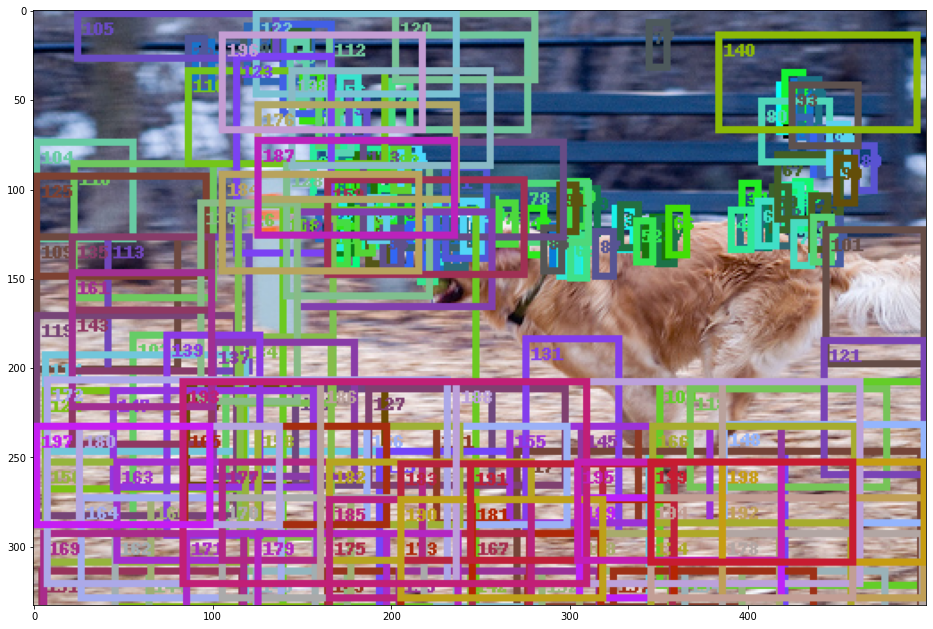

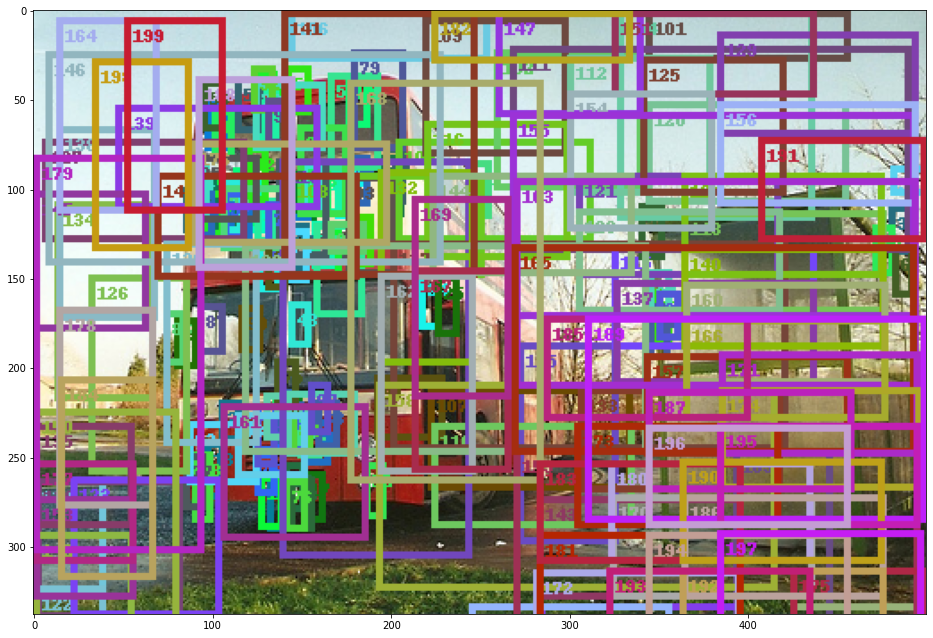

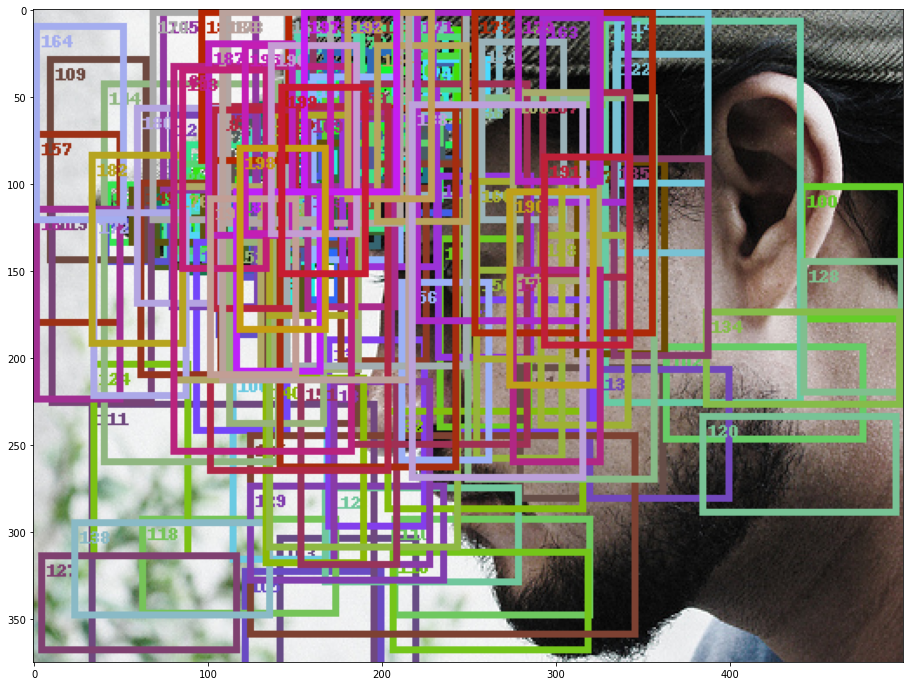

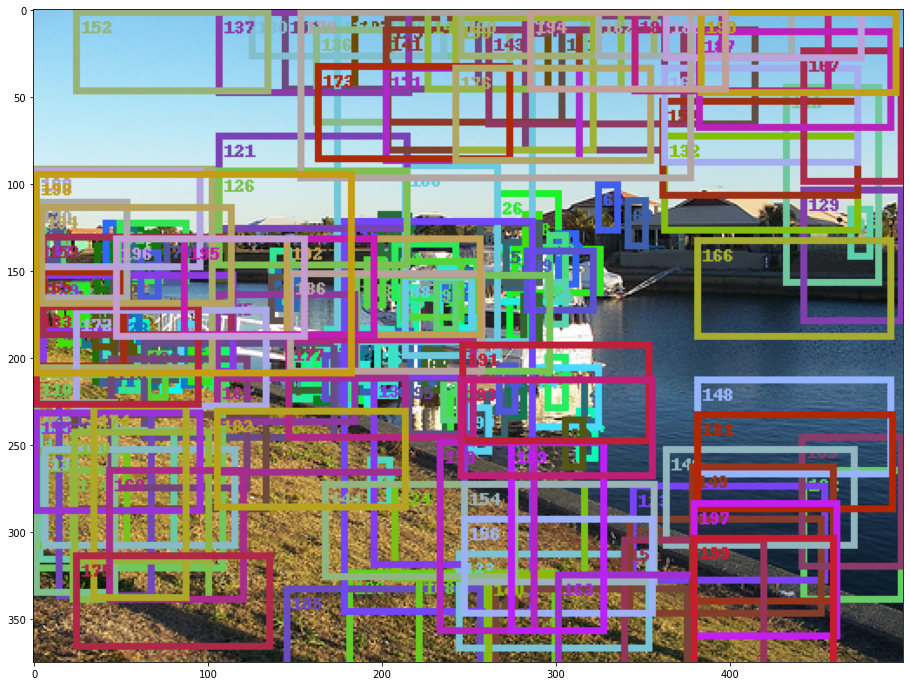

In [126]:
from torchvision.transforms import ToPILImage, functional as F
result = []
for res in range(len(pilIMAGE)):
    boxes = result_box[res]
    labels = [str(i) for i in range(len(boxes))]
        
    drawn_boxes = draw_bounding_boxes(pilIMAGE[res], boxes=boxes, labels=labels, width=4, font_size=30)
    result.append(F.to_pil_image(drawn_boxes))

for i in result:
    fig = plt.figure(figsize=(16, 12))
    plt.subplot(1, 1, 1)
    plt.imshow(i)